<a href="https://colab.research.google.com/github/eliiks/recipes_bot/blob/main/recipes_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recipes Bot

In [1]:
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## 1 - Téléchargement du dataset "Fruits 360"

In [3]:
!git clone https://github.com/Horea94/Fruit-Images-Dataset

fatal: destination path 'Fruit-Images-Dataset' already exists and is not an empty directory.


In [4]:
%cd "./Fruit-Images-Dataset"
%ls

/content/Fruit-Images-Dataset
LICENSE  papers/  readme.md  src/  Test/  test-multiple_fruits/  Training/


In [5]:
train_dir = "./Training/"
test_dir = "./Test/"

In [6]:
images_train = []
images_test = []
labels_train = []
labels_test = []

for label_train in os.listdir(train_dir):
  label_dir = train_dir+label_train+"/"
  for image_file in os.listdir(label_dir):
    labels_train.append(label_train)
    images_train.append(np.array(Image.open(label_dir+image_file).convert("RGB")))

for label_test in os.listdir(test_dir):
  label_dir = test_dir+label_test+"/"
  for image_file in os.listdir(label_dir):
    labels_test.append(label_test)
    images_test.append(np.array(Image.open(label_dir+image_file).convert("RGB")))

In [7]:
print("Train / Taille dataset d'images: ", np.array(images_train).shape)
print("Train / Taille labels: ", len(labels_train), "\n")
print("Test / Taille dataset d'images: ", np.array(images_test).shape)
print("Test / Taille labels: ", len(labels_test))

Train / Taille dataset d'images:  (67692, 100, 100, 3)
Train / Taille labels:  67692 

Test / Taille dataset d'images:  (22688, 100, 100, 3)
Test / Taille labels:  22688


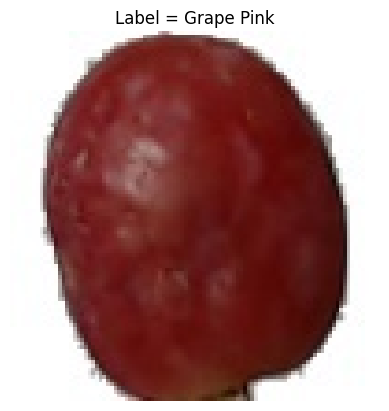

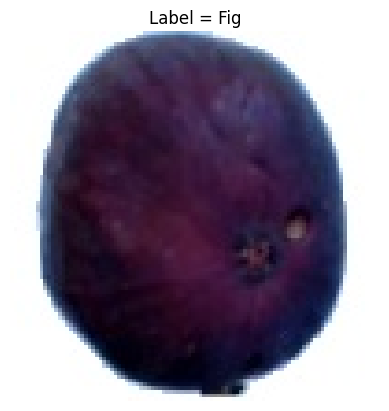

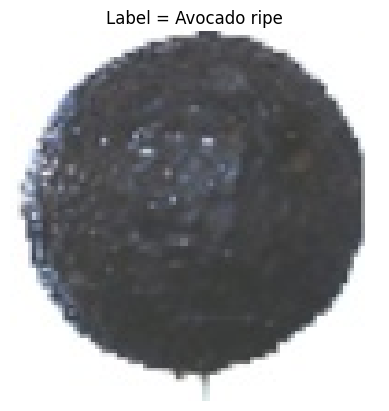

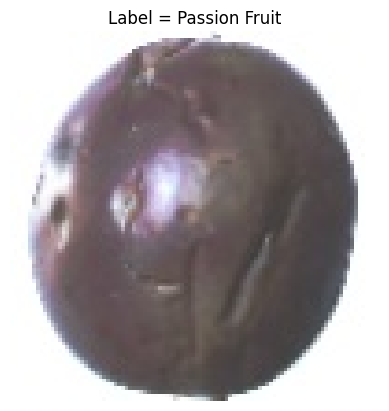

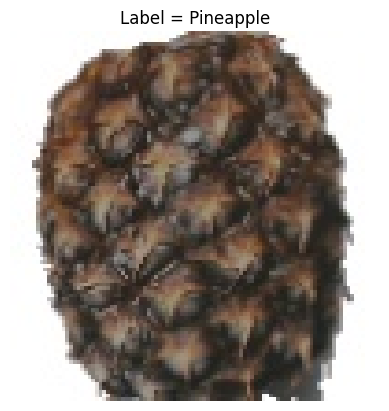

In [8]:
# Affichage 5 images random du dataset de train avec leurs labels
for i in range(5):
  index = np.random.randint(low=0, high=len(labels_train))
  image = images_train[index]
  label = labels_train[index]
  plt.title("Label = " + label)
  plt.imshow(image)
  plt.axis("off")
  plt.show()

## 4 - Modèle LLM

In [9]:
!pip install git+https://github.com/bofenghuang/vigogne

  Cloning https://github.com/bofenghuang/vigogne to /tmp/pip-req-build-fbt8dxi0
  Running command git clone --filter=blob:none --quiet https://github.com/bofenghuang/vigogne /tmp/pip-req-build-fbt8dxi0
  Resolved https://github.com/bofenghuang/vigogne to commit 67ea8a2a06f1ddd5652da274c9d537e2223468bc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/huggingface/accelerate.git to /tmp/pip-install-gwmvgoff/accelerate_47611bb2e21c45af9346db3b4a99d5db
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate.git /tmp/pip-install-gwmvgoff/accelerate_47611bb2e21c45af9346db3b4a99d5db
  Resolved https://github.com/huggingface/accelerate.git to commit d25efa71ce76a5f5911a1fc6c039979d7248596f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (p

In [10]:
from typing import Dict, List, Optional
from transformers import  AutoModelForCausalLM, AutoTokenizer, GenerationConfig, TextStreamer

In [1]:
model_name_or_path = "bofenghuang/vigostral-7b-chat"
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, padding_side="right", use_fast=False)
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.float16, device_map="auto").to(device)
streamer = TextStreamer(tokenizer, timeout=10.0, skip_prompt=True, skip_special_tokens=True)

def chat(
    query: str,
    history: Optional[List[Dict]] = None,
    temperature: float = 0.7,
    top_p: float = 1.0,
    top_k: float = 0,
    repetition_penalty: float = 1.1,
    max_new_tokens: int = 1024,
    **kwargs,
):
    if history is None:
        history = []

    history.append({"role": "user", "content": query})

    input_ids = tokenizer.apply_chat_template(history, return_tensors="pt").to(model.device)
    input_length = input_ids.shape[1]

    generated_outputs = model.generate(
        input_ids=input_ids,
        generation_config=GenerationConfig(
            temperature=temperature,
            do_sample=temperature > 0.0,
            top_p=top_p,
            top_k=top_k,
            repetition_penalty=repetition_penalty,
            max_new_tokens=max_new_tokens,
            pad_token_id=tokenizer.eos_token_id,
            **kwargs,
        ),
        streamer=streamer,
        return_dict_in_generate=True,
    )

    generated_tokens = generated_outputs.sequences[0, input_length:]
    generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)

    history.append({"role": "assistant", "content": generated_text})

    return generated_text, history


# 1st round
response, history = chat("Un escargot parcourt 100 mètres en 5 heures. Quelle est sa vitesse ?", history=None)

# 2nd round
response, history = chat("Quand il peut dépasser le lapin ?", history=history)

# 3rd round
response, history = chat("Écris une histoire imaginative qui met en scène une compétition de course entre un escargot et un lapin.", history=history)


NameError: ignored

In [ ]:
def give_n_recipes(list_fruits, n_recipes=2):
  prompt = "Donne une liste de "+ str(n_recipes) +" recettes connues étape par étape que je peux faire avec cette liste de fruits et légumes : "
  for f in list_fruits:
    prompt += f + " ; "
  print(chat(prompt))

## 3 - Demande utilisateur et saisie des ingrédients

### A - Saisie des fruits et légumes

In [ ]:
def ask_user_fruits_and_vegetables():
  list_fruits = []

  print("Donnez la liste des fruits et des légumes que vous possèdez")
  print("Assurez-vous que le fruit existe et que son ortographe soit correct")
  print("Lorsque vous avez fini, saissisez \"stop\" \n")

  while True:
    list_fruits = []
    choice = input("Saisir un fruit ou un légume (saisir stop pour arrêter) : ")
    while choice != "stop":
      list_fruits.append((choice.strip().lower().replace(" ", "")))
      choice = input("Saisir un fruit ou un légume (saisir stop pour arrêter) : ")
    print("Validez-vous cette liste ? :")
    print(list_fruits)
    confirm = input("Saisir 1 pour confirmer, 2 pour refaire la liste : ")
    while confirm != "1" and confirm != "2":
      confirm = input("Mauvaise saisie, saisir 1 pour confirmer, 2 pour refaire la liste : ")
    if confirm == "1": break
  return list_fruits

In [ ]:
listf = ask_user_fruits_and_vegetables()
print(listf)

### C - Demande utilisateur

In [ ]:
def ask_user():
  print("Bonjour, bienvenue sur Recipes Bot !!")

  # Liste fruits et légumes
  list_fruits = []
  print("Comment souhaitez-vous saisir la liste des fruits et des ingrédients ?")
  print("1 - Avec une photo \n2 - Par saisie de texte")
  choice = input("Saisissez le numéro de votre choix : ")
  while choice != "1" and choice != "2":
    choice = input("Mauvaise saisie! Tapez un numéro entre 1 et 2 selon votre choix : ")
  if choice == "1":
    # detection fruits dans photo
    pass
  elif choice == "2":
    print("")
    list_fruits = ask_user_fruits_and_vegetables()
  print("\nVoici la liste des fruits et légumes : ")
  print(list_fruits, "\n")

  # Génération des 10 recettes
  give_n_recipes(list_fruits, n_recipes=2)

In [ ]:
ask_user()